In [1]:
import csv

DATADIRECTORY="./simData"
IMAGEDIRECTORY="./simData/IMG"
DRIVINGLOG=DATADIRECTORY+"/driving_log.csv"
lines=[]
with open(DRIVINGLOG) as csvFile:
    reader=csv.reader(csvFile)
    for line in reader:
        lines.append(line)
print("lines:", len(lines))

import cv2

CENTERIMAGE=0
STEERINGMEASUEMENT=3
CAMERAS=3
# CENTER, LEFT, RIGHT
STERRINGADJUSTMENT=[0, .25, -.25]

BATCHSIZE=64
BATCHSIZE=32 #flipped images


lines: 12962


In [2]:
import cv2
import numpy as np
import sklearn

AUGMENTEDIMAGESBY=3
AUGMENTEDIMAGESBY=6 # add flipped images

def readImage(imagePathOnRemote):
    filename=imagePathOnRemote.split("/")[-1]
    imagePath=IMAGEDIRECTORY+"/"+filename
    image=cv2.imread(imagePath)
    #print("imagePath:", imagePath, "image.shape:", image.shape)
    return image;

def generator(lines, batchSize=128, shuffleData=True):
    #print("lines:", len(lines))
    numberOfSamples = len(lines)
    while 1: # Loop forever so the generator never terminates
        if shuffleData:
            lines=sklearn.utils.shuffle(lines) # every epoch
        #print("shuffled lines:", len(lines))
        for offset in range(0, numberOfSamples, batchSize):
            batchOfLines = lines[offset:offset+batchSize]

            images=[]
            steeringMeasurements=[]

            for line in batchOfLines:
                for camera in range(CAMERAS):
                    imagePathOnRemote=line[camera]
                    image=readImage(imagePathOnRemote)
                    if (image is None):
                        print ("line:", line)
                        print("image:", image, ", imagePath:", imagePath)
                        exit
                    images.append(image)
                    steering=float(line[STEERINGMEASUEMENT])+STERRINGADJUSTMENT[camera]
                    steeringMeasurements.append(steering)
                    images.append(cv2.flip(image,1))
                    steeringMeasurements.append(steering*-1)
                    assert len(images)==len(steeringMeasurements)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(steeringMeasurements)
            assert len(X_train)==len(y_train)
            #print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
            #print("X_train[0].shape:", X_train[0].shape)
            if shuffleData:
                X_train, y_train=sklearn.utils.shuffle(X_train, y_train)
            yield X_train, y_train

In [3]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("train_samples:", len(train_samples), "validation_samples:", len(validation_samples))
print("train_samples[0]:",len(train_samples[0]))

# compile and train the model using the generator function
train_generator = generator(train_samples, batchSize=BATCHSIZE)
validation_generator = generator(validation_samples, batchSize=BATCHSIZE)

observe_train_generator = generator(train_samples, batchSize=BATCHSIZE, shuffleData=False)
firstTrainingBatch, firstSteeringBatch=next(observe_train_generator)
print("train_generator:", len(firstTrainingBatch))
print("firstTrainingBatch.shape:",firstTrainingBatch.shape, ", firstSteeringBatch.shape:", firstSteeringBatch.shape)
assert len(firstTrainingBatch) == len(firstSteeringBatch)
assert len(firstTrainingBatch) == AUGMENTEDIMAGESBY*BATCHSIZE

train_samples: 10369 validation_samples: 2593
train_samples[0]: 7
train_generator: 192
firstTrainingBatch.shape: (192, 160, 320, 3) , firstSteeringBatch.shape: (192,)


images.shape: (192, 160, 320, 3) , steeringAngles.shape: (192,)
augmentedImageBatchSize: 6 , augmentedImageBatches: 32
randomAugmentedImageBatchIndicies: [18, 6, 21] sizeOnScreen: (80.0, 160.0)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)


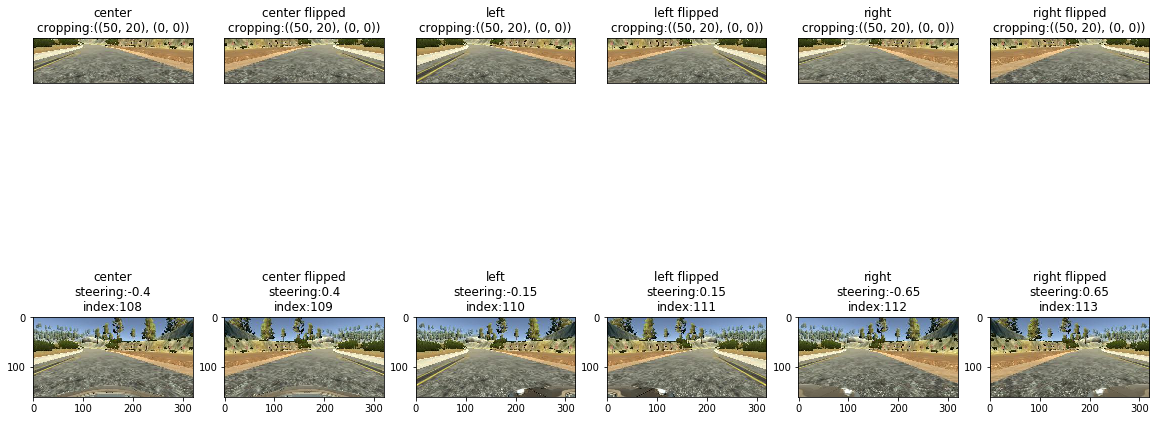

cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)


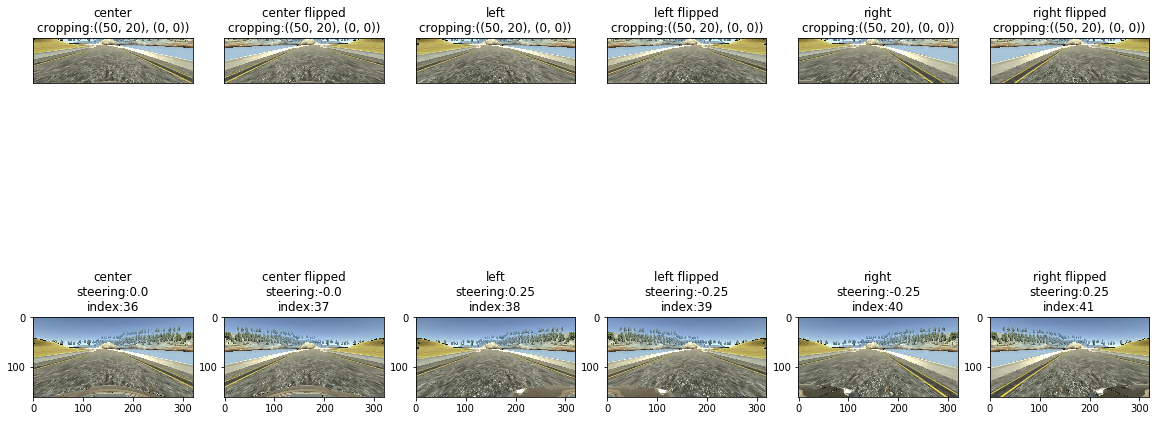

cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)
cropY: (50, 140) , cropX: (0, 320)


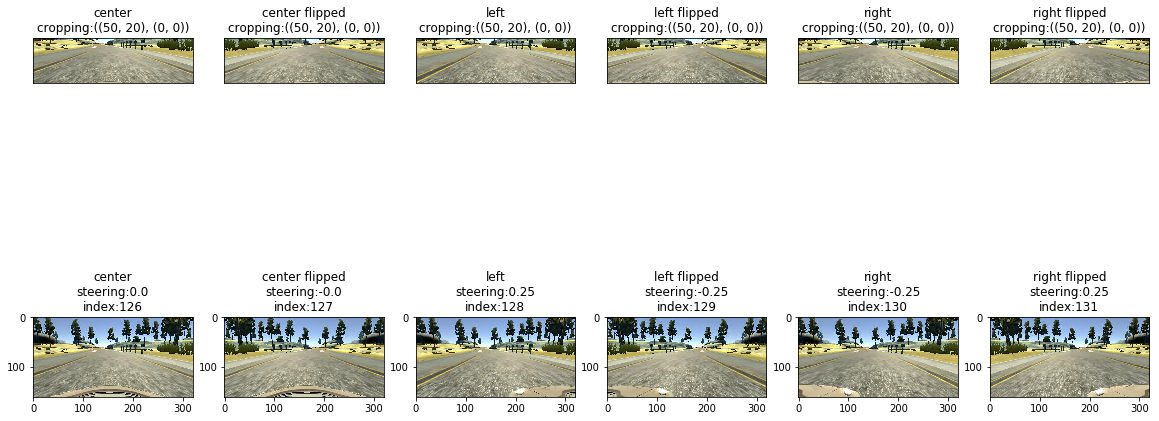

In [4]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

IMAGECROP=((50,20), (0,0))

imageNames=["center", "left", "right"]
imageNames=["center", "center flipped", "left", "left flipped","right", "right flipped"]
NUMBEROFSAMPLESTOSHOW=3

def plot_images(images, steeringAngles, imageNames):
    print("images.shape:",images.shape, ", steeringAngles.shape:", steeringAngles.shape)
    assert len(images) == len(steeringAngles)
    imageShape = (images.shape[1], images.shape[2])
    augmentedImageBatchSize=len(imageNames)
    augmentedImageBatches = int(len(images)/augmentedImageBatchSize)
    print("augmentedImageBatchSize:",augmentedImageBatchSize, ", augmentedImageBatches:", augmentedImageBatches)
   
    randomAugmentedImageBatchIndicies=random.sample(range(0,augmentedImageBatches), NUMBEROFSAMPLESTOSHOW)
    #randomAugmentedImageBatchIndicies=(0,1,2)
    sizeOnScreen=(images[0].shape[0]/2, images[0].shape[1]/2)
    print ("randomAugmentedImageBatchIndicies:",randomAugmentedImageBatchIndicies, "sizeOnScreen:", sizeOnScreen)
    for augmentedBatchIndex in range(len(randomAugmentedImageBatchIndicies)):
    #for augmentedBatchIndex in range(0,1):
        randomAugmentedBatchIndex=randomAugmentedImageBatchIndicies[augmentedBatchIndex]
        beginningListIndexForBatch=augmentedImageBatchSize*randomAugmentedBatchIndex
        #print("augmentedBatchIndex:", augmentedBatchIndex,", randomAugmentedImageBatchIndicies:", randomAugmentedImageBatchIndicies, ", beginningListIndexForBatch:", beginningListIndexForBatch)
        #print("beginningListIndexForBatch:", beginningListIndexForBatch, "from batch:", randomAugmentedBatchIndex)
        batchFigure=plt.figure(augmentedBatchIndex+1, figsize=(20,20))
        #batchFigure=plt.figure(augmentedBatchIndex+1)
        batchFigureTitle="batch #"+str(randomAugmentedBatchIndex)+"("+str(beginningListIndexForBatch)+") of "+str(augmentedImageBatches)
        #print("batchFigureTitle:", batchFigureTitle)
        #batchFigure.suptitle(batchFigureTitle)
        for imageId in range(augmentedImageBatchSize):
            listIndex=beginningListIndexForBatch+imageId
            imageToPlot=cv2.cvtColor(images[listIndex], cv2.COLOR_BGR2RGB)
            axis=batchFigure.add_subplot(1, augmentedImageBatchSize, imageId+1)
            subplotTitle=imageNames[imageId]+"\nsteering:"+str(steeringAngles[listIndex])+"\nindex:"+str(listIndex)
            #print("subplotTitle:", subplotTitle)
            axis.set_title(subplotTitle)
            #plt.subplot(1, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            plt.imshow(imageToPlot)
            cropY=(IMAGECROP[0][0],imageToPlot.shape[0]-IMAGECROP[0][1])
            cropX=(IMAGECROP[1][0],imageToPlot.shape[1]-IMAGECROP[1][1])
            print("cropY:", cropY, ", cropX:", cropX)
            croppedImage=imageToPlot[cropY[0]:cropY[1],cropX[0]:cropX[1],:]
            axis=batchFigure.add_subplot(2, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            subplotTitle=imageNames[imageId]+"\ncropping:"+str(IMAGECROP)
            #print("subplotTitle:", subplotTitle)
            axis.set_title(subplotTitle)
            #plt.subplot(1, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            plt.imshow(croppedImage)
        plt.show()
        plt.close()
    
plot_images(firstTrainingBatch, firstSteeringBatch, imageNames)



In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras as keras

sampleImage=readImage(lines[0][0])
print("sampleImage.shape:", sampleImage.shape)
XtrainInputShape=sampleImage.shape[0:len(sampleImage.shape)]
print ("XtrainInputShape:", XtrainInputShape)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=XtrainInputShape, output_shape=XtrainInputShape))
#model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=XtrainInputShape, output_shape=XtrainInputShape))
#model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(3,80,320), output_shape=(3,80,320)))

model.add(Cropping2D(cropping=IMAGECROP))

# nvidia model
#model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
model.add(Convolution2D(24, 5, 5))
model.add(MaxPooling2D())
model.add(Activation('relu'))

#model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
model.add(Convolution2D(36, 5, 5))
model.add(MaxPooling2D())
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))

model.add(Flatten())
model.add(Dropout(.2))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

##
model.add(Dense(1))

adamOptimizer=keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adamOptimizer)
#model.compile(loss='mse', optimizer='adam')

history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples), nb_epoch=10)

#adamOptimizer=keras.optimizers.Adam(lr=0.0001)
#model.compile(optimizer=adamOptimizer, loss='mse', metrics=['accuracy'])
#history_object=model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=50)

import datetime

modelFilename=datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")+".model"
print ("saving model as:", modelFilename)
model.save(modelFilename)

Using TensorFlow backend.


sampleImage.shape: (160, 320, 3)
XtrainInputShape: (160, 320, 3)
Epoch 1/10
10368/10369 [============================>.] - ETA: 0s - loss: 0.0432

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10560/10369 [==============================] - 58s - loss: 0.0429 - val_loss: 0.0333
Epoch 2/10
10560/10369 [==============================] - 54s - loss: 0.0337 - val_loss: 0.0273
Epoch 3/10
10560/10369 [==============================] - 54s - loss: 0.0312 - val_loss: 0.0255
Epoch 4/10
10560/10369 [==============================] - 54s - loss: 0.0275 - val_loss: 0.0272
Epoch 5/10
10560/10369 [==============================] - 54s - loss: 0.0277 - val_loss: 0.0244
Epoch 6/10
10374/10369 [==============================] - 53s - loss: 0.0281 - val_loss: 0.0226
Epoch 7/10
10560/10369 [==============================] - 54s - loss: 0.0292 - val_loss: 0.0260
Epoch 8/10
10560/10369 [==============================] - 54s - loss: 0.0266 - val_loss: 0.0190
Epoch 9/10
10560/10369 [==============================] - 54s - loss: 0.0277 - val_loss: 0.0226
Epoch 10/10
10560/10369 [==============================] - 54s - loss: 0.0268 - val_loss: 0.0239
saving model as: 2017_07_13_00_02.model


dict_keys(['loss', 'val_loss'])
key: loss , values: [0.042943049527027391, 0.033662317760966044, 0.031156178191304208, 0.027496848153797063, 0.027735035307705401, 0.02809152852565033, 0.029159581085497682, 0.026580622673711994, 0.027652778290212156, 0.026768881285732442]
key: val_loss , values: [0.033306489565542767, 0.027305489938173975, 0.025546922082347528, 0.027229143974510227, 0.024352546382163252, 0.022609239710228785, 0.025950332438307151, 0.018981349055788348, 0.022602656190948828, 0.023937234056315253]


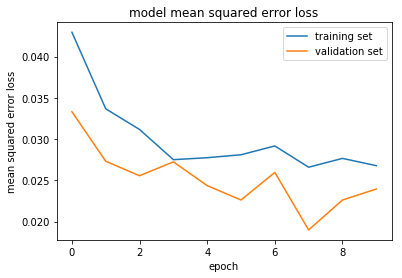

In [6]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())
for key in history_object.history.keys():
    print ("key:", key,", values:", history_object.history[key])

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()